# Mastodon analysis
Expected to be run in a notebook

[DuckDB in Jupyter Notebooks](https://duckdb.org/docs/guides/python/jupyter)

In [8]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

In [113]:
import duckdb
import pandas as pd
import seaborn as sns

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql
%sql duckdb:///:memory:

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [70]:

# %sql duckdb:///path/to/file.db

In [71]:
%%sql
INSTALL httpfs;
LOAD httpfs;

""


In [100]:
%%sql
drop table if exists mastodon_toot_raw;
drop table if exists mastodon_toot;
drop table if exists language;

CREATE TABLE language(lang_iso VARCHAR PRIMARY KEY, language_name VARCHAR);

insert into language
select *
from read_csv('../duckdb/language.csv', AUTO_DETECT=TRUE, header=True);

create table mastodon_toot_raw as
select m_id
, created_at, ('EPOCH'::TIMESTAMP + INTERVAL (created_at::INT) seconds)::TIMESTAMPTZ  as created_tz
, app
, url
, regexp_replace(regexp_replace(url, '^http[s]://', ''), '/.*$', '') as from_instance
, base_url
, language
, favourites
, username
, bot
, tags
, characters
, mastodon_text
FROM read_parquet('../data_tmp/mastodon-topic*');

create table mastodon_toot as
select mr.*, ln.language_name
from mastodon_toot_raw mr left outer join language ln on (mr.language = ln.lang_iso);

,Count
0,929000


# The Mastodon app landscape
What clients are used to access mastodon instances

In [101]:
%%sql
mastodon_app_df << 
select *
from mastodon_toot
where app is not null and app <>''
;

Returning data to local variable mastodon_app_df


<AxesSubplot: xlabel='count', ylabel='app'>

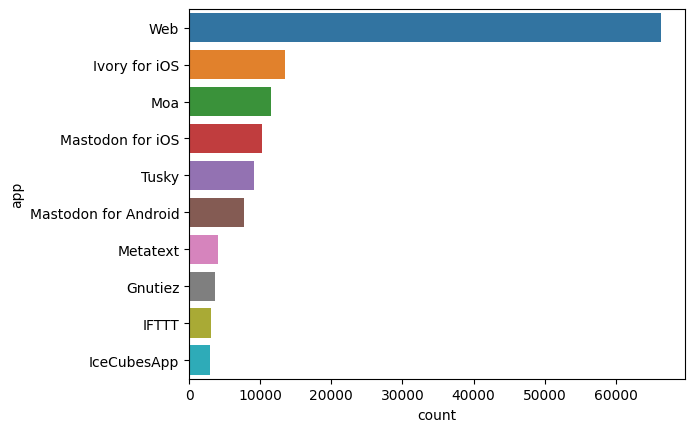

In [102]:
sns.countplot(data=mastodon_app_df, y="app", order=mastodon_app_df.app.value_counts().iloc[:10].index)

In [103]:
%%sql
select strftime(created_tz, '%Y/%m/%d %a') as created_day
, count(*) as num_toots
, count(distinct(username)) as num_users
, count(distinct(from_instance)) as num_urls
from mastodon_toot
group by 1
order by 1
;

,created_day,num_toots,num_users,num_urls
0,2023/02/04 Sat,197977,49105,4328
1,2023/02/05 Sun,207464,49241,4310
2,2023/02/06 Mon,45293,17846,2255
3,2023/02/07 Tue,106522,30701,3350
4,2023/02/08 Wed,218059,51818,4494
5,2023/02/09 Thu,153685,45767,4114


In [104]:
%%sql
mastodon_usage_df << 
select strftime(created_tz, '%Y/%m/%d %a') as created_day
, date_part('hour', created_tz) as created_hour
, count(*) as num
from mastodon_toot
group by 1,2 
order by 1,2
;

Returning data to local variable mastodon_usage_df


<AxesSubplot: xlabel='created_hour', ylabel='num'>

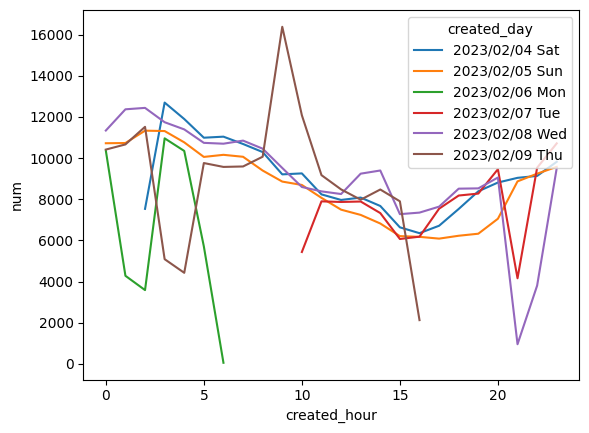

In [105]:
# sns.lineplot(data=mastodon_usage_df, x="created_hour", y="num")
sns.lineplot(data=mastodon_usage_df, x="created_hour", y="num", hue="created_day")

# Language usage
A wildly inaccurate investigation of language tags

In [106]:
%%sql
mastodon_usage_df << 
select *
from mastodon_toot;

Returning data to local variable mastodon_usage_df


<AxesSubplot: xlabel='count', ylabel='language_name'>

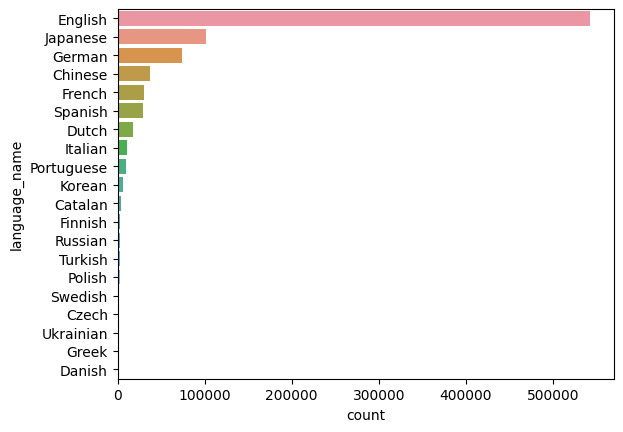

In [107]:
sns.countplot(data=mastodon_usage_df, y="language_name", order=mastodon_usage_df.language_name.value_counts().iloc[:20].index)

In [108]:
%%sql
mastodon_lang_df << 
select *
from mastodon_toot
where characters < 200
and language not in ('unknown');

Returning data to local variable mastodon_lang_df


<AxesSubplot: xlabel='characters', ylabel='language_name'>

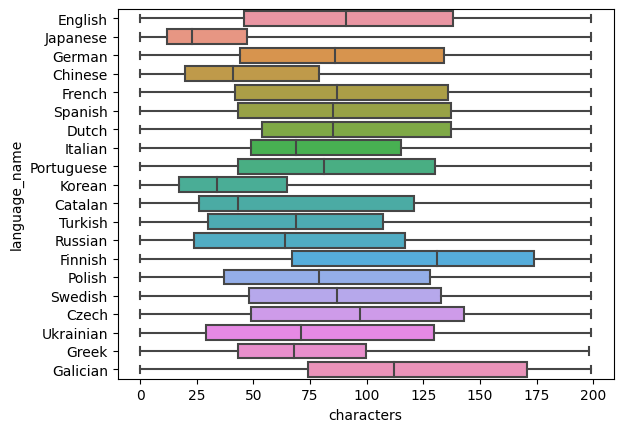

In [112]:
sns.boxplot(data=mastodon_lang_df, x="characters", y="language_name", whis=100, orient="h", order=mastodon_lang_df.language_name.value_counts().iloc[:20].index)
